# Dataset

In [1]:
import os
import numpy as np
from tqdm import tqdm
import random
import cv2
import albumentations as A
from IPython.display import clear_output
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from utils import create_dataset, visualize, augment_batch, count_parameters, train, evaluate, epoch_time, test_accuracy

In [3]:
PATH_train = './monkey/training/training'
PATH_val = './monkey/validation/validation'

monkey_classes = ['alouatta_palliata', 
                  'erythrocebus_patas', 
                  'cacajao_calvus', 
                  'macaca_fuscata', 
                  'cebuella_pygmea', 
                  'cebus_capucinus', 
                  'mico_argentatus', 
                  'saimiri_sciureus', 
                  'aotus_nigriceps', 
                  'trachypithecus_johnii']
                
transform_resize = A.Compose([A.Resize(height=512, width=512)])

x_train, y_train = create_dataset(PATH_train, monkey_classes)
x_val, y_val = create_dataset(PATH_val, monkey_classes)

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


In [4]:
len(x_train), len(x_val)

(1098, 272)

# Augmentation

In [5]:
transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.Resize(height=512, width=512)
    ])

torch.Size([3, 512, 512])


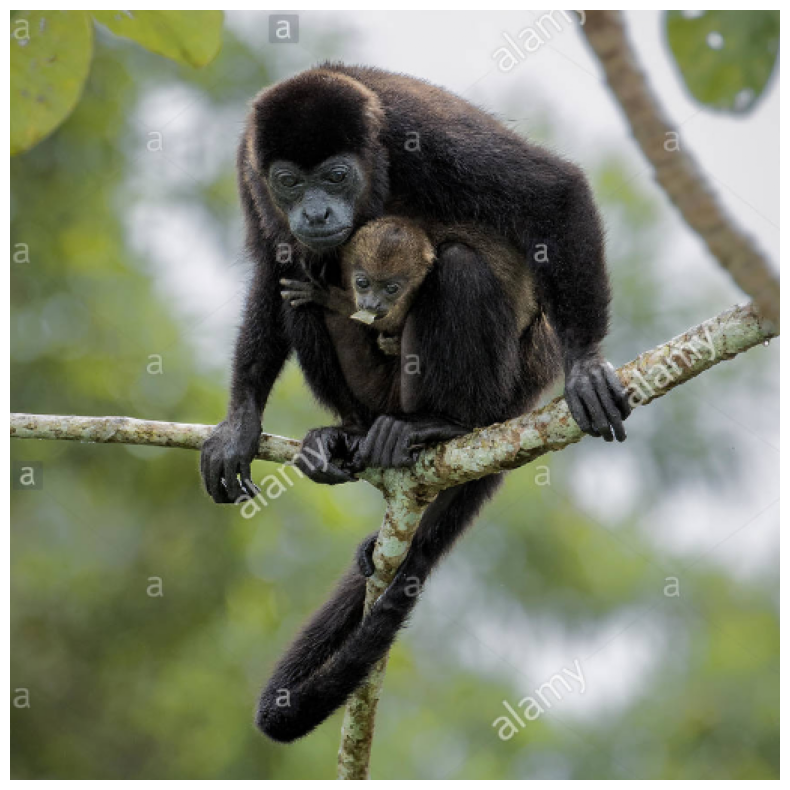

In [6]:
print(x_train[0].shape)
visualize(x_train[0].permute(1, 2, 0))

torch.Size([512, 512, 3])


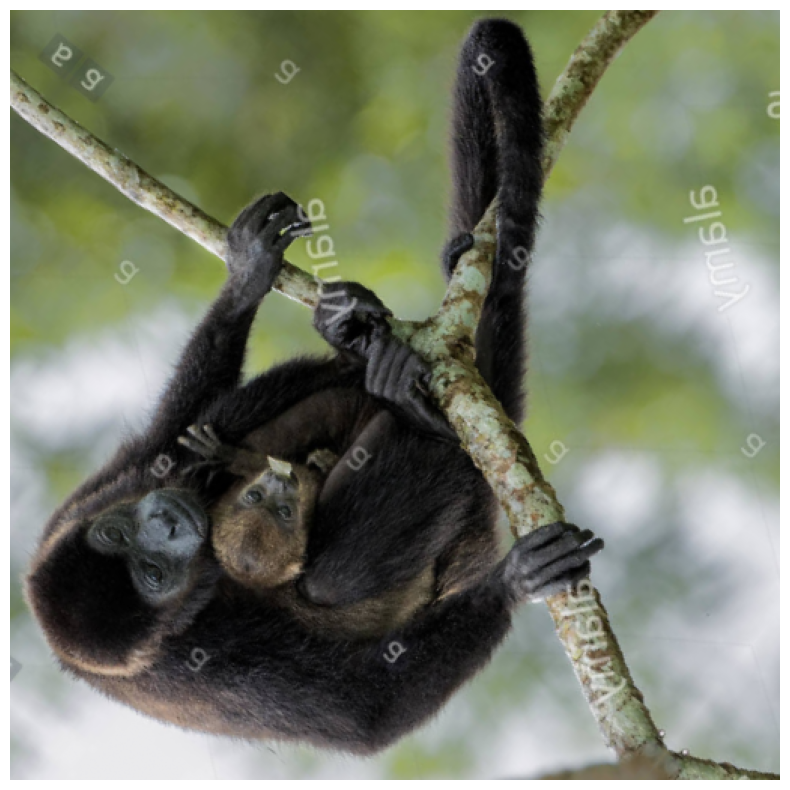

In [7]:
augmented_image = torch.from_numpy(transform(image=np.array(x_train[0].permute(1, 2, 0)))['image'])
print(augmented_image.shape)
visualize(augmented_image)

# Dataloader

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(list(zip(x_train, y_train)), batch_size=4, shuffle=True)
val_dataloader = DataLoader(list(zip(x_val, y_val)), batch_size=4, shuffle=False)

## VGG.

In [34]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()) # b_s x 3 x 512 x 512 -> b_s x 64 x 512 x 512
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 64 x 512 x 512 -> b_s x 64 x 256 x 256
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()) # b_s x 64 x 256 x 256 -> b_s x 128 x 256 x 256
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 128 x 256 x 256 -> b_s x 128 x 128 x 128
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()) # b_s x 128 x 128 x 128 -> b_s x 256 x 128 x 128
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 256 x 128 x 128 -> b_s x 256 x 64 x 64
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()) # b_s x 256 x 64 x 64 -> b_s x 512 x 64 x 64
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 64 x 64 -> b_s x 512 x 32 x 32
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 32 x 32 -> b_s x 512 x 16 x 16
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 16 x 16 -> b_s x 1024 x 8 x 8

        self.layer11 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 1024 x 8 x 8 -> b_s x 1024 x 4 x 4
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=4, stride=1, padding=0)) # b_s x 1024 x 4 x 4 -> b_s x 1024 x 1 x 1
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU())
        
        self.fc2= nn.Linear(1024, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [35]:
model = VGG16(10)
device = 'cuda'
model = model.to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 39,050,058 trainable parameters


In [18]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    out = model(x.to(device))
    print(out.shape)
    aug_x = augment_batch(x)
    print(aug_x.shape)
    break

torch.Size([8, 3, 512, 512]) torch.Size([8])
torch.Size([8, 10])
torch.Size([8, 3, 512, 512])


# Train

In [20]:
train_history = []
valid_history = []

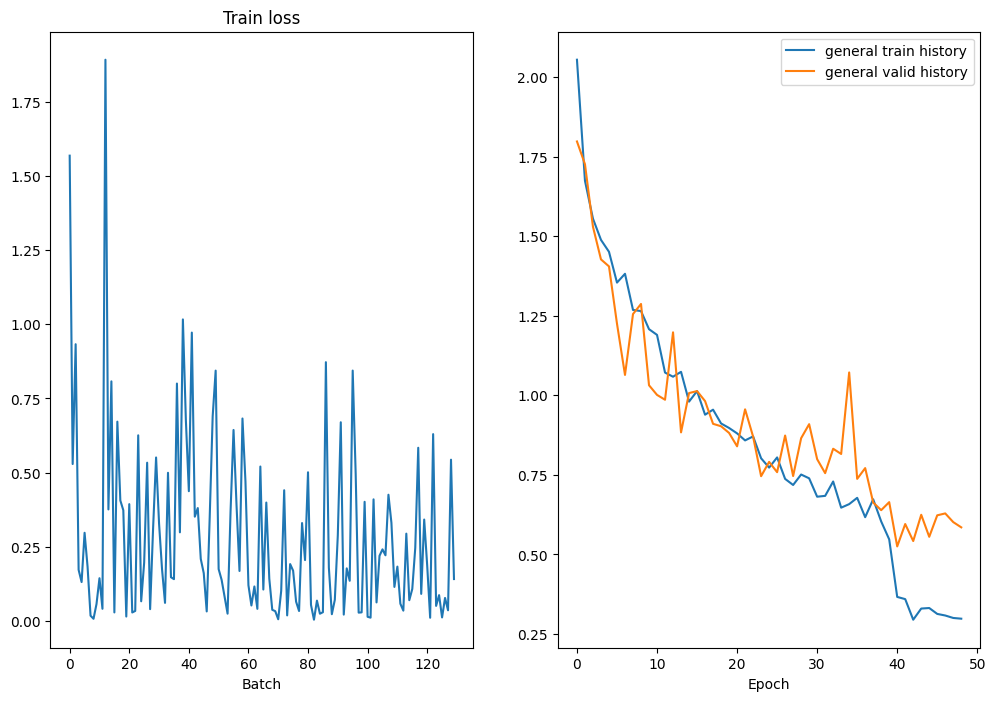

Epoch: 05 | Time: 1m 45s
	Train Loss: 0.301 | Train PPL:   1.351
	 Val. Loss: 0.571 |  Val. PPL:   1.771


In [39]:
import math
import time

N_EPOCHS = 5
CLIP = 5
lr = 10**(-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, device, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, device, val_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# Test and metrics

In [15]:
test_accuracy(model, device, val_dataloader, 'best-val-model.pt')

81.61764705882354

# EfficientNet_B4

In [9]:
from torchvision.models import efficientnet_b3

class EfficientNet_B3(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNet_B3, self).__init__()
        
        self.model = efficientnet_b3(pretrained=True)
        in_feat = list(list(self.model.children())[-1])[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_feat, num_classes)
        
    def forward(self, x):
        out = self.model(x)
        return out

In [10]:
model_1 = EfficientNet_B3(10)
device = 'cuda'
model_1 = model_1.to(device)
print(f'The model has {count_parameters(model_1):,} trainable parameters')

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The model has 10,711,602 trainable parameters


In [11]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    out = model_1(x.to(device))
    print(out.shape)
    aug_x = augment_batch(x)
    print(aug_x.shape)
    break

torch.Size([4, 3, 512, 512]) torch.Size([4])
torch.Size([4, 10])
torch.Size([4, 3, 512, 512])


In [12]:
train_history_1 = []
valid_history_1 = []

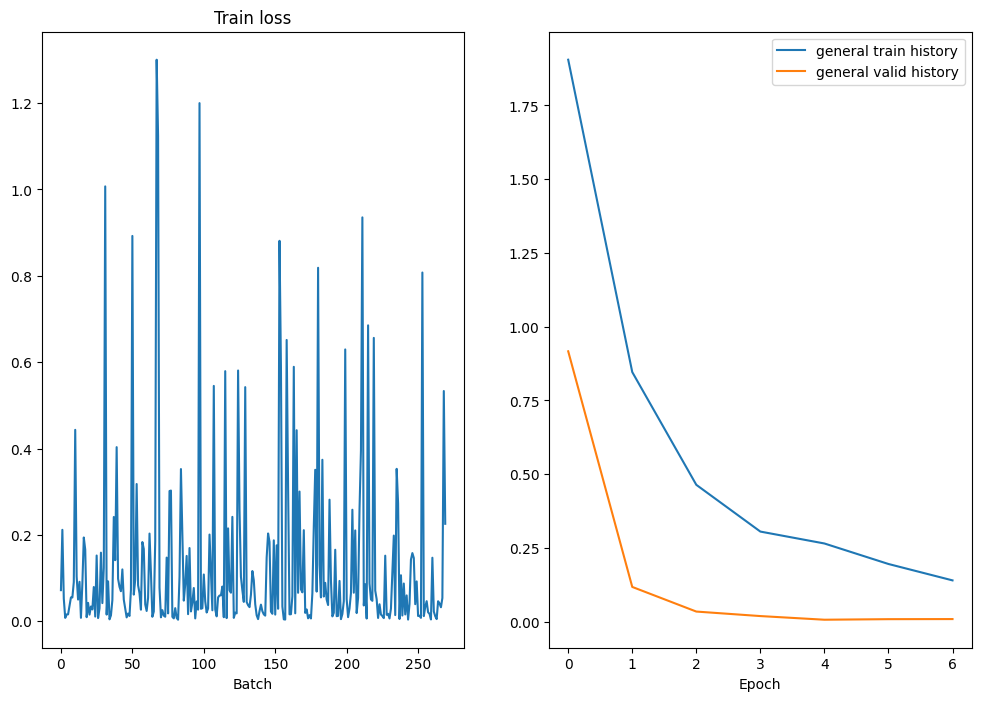

Epoch: 02 | Time: 1m 20s
	Train Loss: 0.133 | Train PPL:   1.142
	 Val. Loss: 0.003 |  Val. PPL:   1.003


In [14]:
import math
import time

N_EPOCHS = 2
CLIP = 5
lr = 10**(-5)
optimizer = torch.optim.AdamW(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

best_valid_loss_1 = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss_1 = train(model_1, device, train_dataloader, optimizer, criterion, CLIP, train_history_1, valid_history_1)
    valid_loss_1 = evaluate(model_1, device, val_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss_1 < best_valid_loss_1:
        best_valid_loss_1 = valid_loss_1
        torch.save(model_1.state_dict(), './best-val-model-1.pt')
    
    train_history_1.append(train_loss_1)
    valid_history_1.append(valid_loss_1)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_1:.3f} | Train PPL: {math.exp(train_loss_1):7.3f}')
    print(f'\t Val. Loss: {valid_loss_1:.3f} |  Val. PPL: {math.exp(valid_loss_1):7.3f}')

In [15]:
test_accuracy(model_1, device, val_dataloader, 'best-val-model-1.pt')

100.0

# DenseNet169

In [26]:
from torchvision.models import densenet169

class DenseNet169(nn.Module):
    def __init__(self, num_classes=10):
        super(DenseNet169, self).__init__()
        
        self.model = densenet169(pretrained=True)
        in_feat = list(self.model.children())[-1].in_features
        self.model.classifier = nn.Linear(in_feat, num_classes)
        
    def forward(self, x):
        out = self.model(x)
        return out

In [27]:
model_2 = DenseNet169(10)
device = 'cuda'
model_2 = model_2.to(device)
print(f'The model has {count_parameters(model_2):,} trainable parameters')

The model has 12,501,130 trainable parameters


In [28]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    out = model_2(x.to(device))
    print(out.shape)
    aug_x = augment_batch(x)
    print(aug_x.shape)
    break

torch.Size([4, 3, 512, 512]) torch.Size([4])
torch.Size([4, 10])
torch.Size([4, 3, 512, 512])


In [29]:
train_history_2 = []
valid_history_2 = []

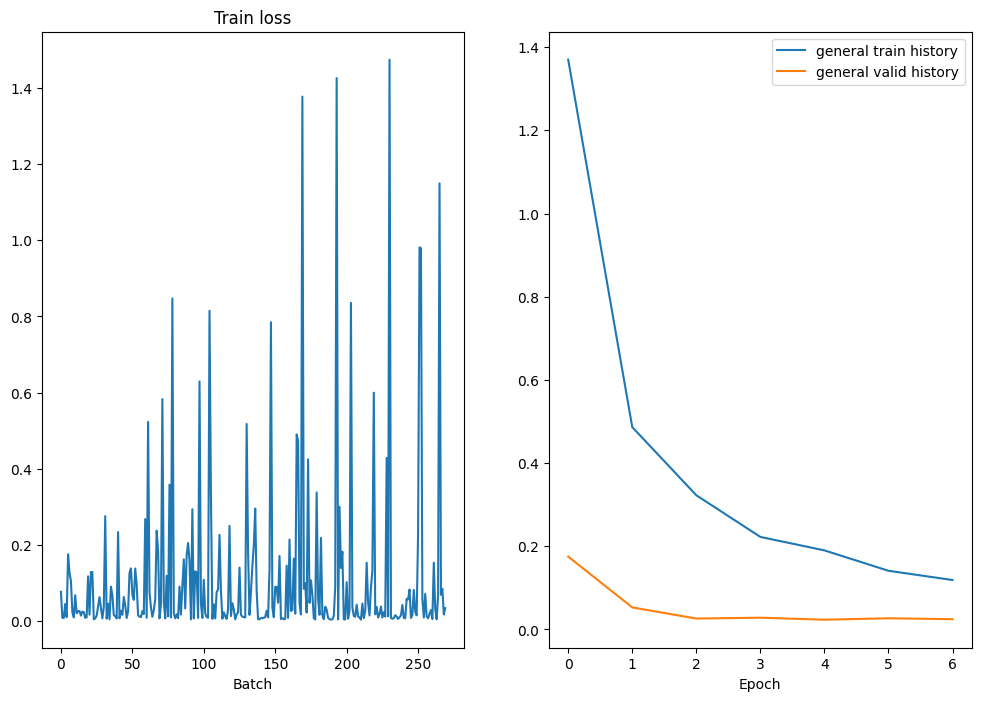

Epoch: 01 | Time: 1m 43s
	Train Loss: 0.133 | Train PPL:   1.142
	 Val. Loss: 0.003 |  Val. PPL:   1.003


In [31]:
import math
import time

N_EPOCHS = 1
CLIP = 5
lr = 0.5*10**(-4)
optimizer = torch.optim.AdamW(model_2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

best_valid_loss_2 = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss_2 = train(model_2, device, train_dataloader, optimizer, criterion, CLIP, train_history_2, valid_history_2)
    valid_loss_2 = evaluate(model_2, device, val_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss_2 < best_valid_loss_2:
        best_valid_loss_2 = valid_loss_2
        torch.save(model_2.state_dict(), './best-val-model-2.pt')
    
    train_history_2.append(train_loss_2)
    valid_history_2.append(valid_loss_2)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_1:.3f} | Train PPL: {math.exp(train_loss_1):7.3f}')
    print(f'\t Val. Loss: {valid_loss_1:.3f} |  Val. PPL: {math.exp(valid_loss_1):7.3f}')

In [32]:
test_accuracy(model_2, device, val_dataloader, 'best-val-model-2.pt')

99.26470588235294

# Summary

3 models were trained::

- VGG from scratch
- pretrained EfficientNet_B4
- pretrained DenseNet169

The following accuracy was obtained on the validation sample:

VGG - 81.6%

EfficientNet_B4 - 100%

DenseNet169 - 99.3%

In [40]:
model.load_state_dict(torch.load('best-val-model.pt'))
model.eval()

model_1.load_state_dict(torch.load('best-val-model-1.pt'))
model_1.eval()

model_2.load_state_dict(torch.load('best-val-model-2.pt'))
model_2.eval()
''

''

In [43]:
true = []
pred = []
pred_1 = []
pred_2 = []

with torch.no_grad():
    for x, y in val_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        output = torch.argmax(output, dim=1)
        
        output_1 = model_1(x)
        output_1 = torch.argmax(output_1, dim=1)
        
        output_2 = model_2(x)
        output_2 = torch.argmax(output_2, dim=1)
        
        for i in range(y.shape[0]):
            true.append(y[i].item())
            pred.append(output[i].item())
            pred_1.append(output_1[i].item())
            pred_2.append(output_2[i].item())

VGG16

In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true, pred)

array([[17,  0,  0,  0,  0,  1,  0,  0,  1,  7],
       [ 0, 18,  0,  3,  1,  2,  1,  2,  0,  1],
       [ 0,  0, 26,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 27,  1,  1,  0,  0,  0,  1],
       [ 2,  0,  0,  0, 22,  0,  1,  0,  1,  0],
       [ 1,  0,  0,  0,  1, 22,  0,  0,  1,  3],
       [ 0,  1,  0,  0,  0,  1, 24,  0,  0,  0],
       [ 0,  0,  1,  0,  3,  2,  2, 20,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0, 25,  0],
       [ 4,  0,  0,  0,  0,  1,  0,  0,  0, 21]])

In [48]:
from sklearn.metrics import classification_report

print(classification_report(true, pred, target_names=monkey_classes))

                       precision    recall  f1-score   support

    alouatta_palliata       0.71      0.65      0.68        26
   erythrocebus_patas       0.95      0.64      0.77        28
       cacajao_calvus       0.96      0.96      0.96        27
       macaca_fuscata       0.87      0.90      0.89        30
      cebuella_pygmea       0.76      0.85      0.80        26
      cebus_capucinus       0.73      0.79      0.76        28
      mico_argentatus       0.86      0.92      0.89        26
     saimiri_sciureus       0.91      0.71      0.80        28
      aotus_nigriceps       0.86      0.93      0.89        27
trachypithecus_johnii       0.64      0.81      0.71        26

             accuracy                           0.82       272
            macro avg       0.82      0.82      0.81       272
         weighted avg       0.83      0.82      0.82       272



EfficientNet_B4

In [49]:
confusion_matrix(true, pred_1)

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 26,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 26]])

In [50]:
print(classification_report(true, pred_1, target_names=monkey_classes))

                       precision    recall  f1-score   support

    alouatta_palliata       1.00      1.00      1.00        26
   erythrocebus_patas       1.00      1.00      1.00        28
       cacajao_calvus       1.00      1.00      1.00        27
       macaca_fuscata       1.00      1.00      1.00        30
      cebuella_pygmea       1.00      1.00      1.00        26
      cebus_capucinus       1.00      1.00      1.00        28
      mico_argentatus       1.00      1.00      1.00        26
     saimiri_sciureus       1.00      1.00      1.00        28
      aotus_nigriceps       1.00      1.00      1.00        27
trachypithecus_johnii       1.00      1.00      1.00        26

             accuracy                           1.00       272
            macro avg       1.00      1.00      1.00       272
         weighted avg       1.00      1.00      1.00       272



DenseNet169

In [53]:
confusion_matrix(true, pred_2)

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 25,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 26]])

In [54]:
print(classification_report(true, pred_2, target_names=monkey_classes))

                       precision    recall  f1-score   support

    alouatta_palliata       0.96      1.00      0.98        26
   erythrocebus_patas       1.00      0.96      0.98        28
       cacajao_calvus       1.00      1.00      1.00        27
       macaca_fuscata       1.00      1.00      1.00        30
      cebuella_pygmea       1.00      0.96      0.98        26
      cebus_capucinus       1.00      1.00      1.00        28
      mico_argentatus       1.00      1.00      1.00        26
     saimiri_sciureus       1.00      1.00      1.00        28
      aotus_nigriceps       1.00      1.00      1.00        27
trachypithecus_johnii       0.96      1.00      0.98        26

             accuracy                           0.99       272
            macro avg       0.99      0.99      0.99       272
         weighted avg       0.99      0.99      0.99       272

